In [1]:
library(ArchR)
library(parallel)
library(biosignals)
set.seed(1)
addArchRThreads(threads = 16) 

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats

In [2]:
addArchRGenome("hg38")

Setting default genome to Hg38.



# Input data

In [3]:
root = '/Genomics/pritykinlab/zzhao/sc-atac-submmit-calling/sc-atac-submmit-calling'
scatac_input = 'data/pbmc10k/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz'
scatac_input = paste(root, scatac_input, sep="/")
out_dir = "results/pbmc_coassay_processed/"
out_dir = paste(root, out_dir, sep="/")
archr_out = "results/pbmc_archR_output/"
archr_out = paste(root, archr_out, sep="/")

In [4]:
archr_out

[1] "/Genomics/pritykinlab/zzhao/sc-atac-submmit-calling/sc-atac-submmit-calling/results/pbmc_archR_output/"

# create arrow files and preprocess data

In [5]:
# Create Arrow files, filter

ArrowFiles <- createArrowFiles(
  inputFiles = c(scatac_input),
  sampleNames = c("coassay_analysis"),
  minTSS = 10, #Dont set this too high because you can always increase later
  minFrags = 2500, # both TSS and Frags have different parameter names from the tutorial, using minFrags and minTSS instead.
  addTileMat = TRUE, # Set to False and add non-binarized matrix for non-binarized LSI using code below
  addGeneScoreMat = TRUE,
  force = TRUE
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

ArchR logging to : ArchRLogs/ArchR-createArrows-12a6a15d2276e-Date-2022-07-24_Time-17-40-39.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2022-07-24 17:40:39 : Batch Execution w/ safelapply!, 0 mins elapsed.

(coassay_analysis : 1 of 1) Determining Arrow Method to use!

2022-07-24 17:40:39 : (coassay_analysis : 1 of 1) Reading In Fragments from inputFiles (readMethod = tabix), 0.001 mins elapsed.

2022-07-24 17:40:39 : (coassay_analysis : 1 of 1) Tabix Bed To Temporary File, 0.001 mins elapsed.

2022-07-24 17:42:59 : (coassay_analysis : 1 of 1) Successful creation of Temporary File, 2.325 mins elapsed.

2022-07-24 17:42:59 : (coassay_analysis : 1 of 1) Creating ArrowFile From Temporary File, 2.325 mins elapsed.

2022-07-24 17:44:33 : (coassay_analysis : 1 of 1) Successful creation of Arrow File, 3.894 mins elapsed.

2022-07-24 17:45:50 : (co

In [6]:
# Inferring doublets

doubScores <- addDoubletScores(
  input = ArrowFiles,
  k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
  knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search.
  LSIMethod = 1
)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-12a6a2ca4523b-Date-2022-07-24_Time-17-52-53.log
If there is an issue, please report to github with logFile!

2022-07-24 17:52:53 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-07-24 17:52:53 : coassay_analysis (1 of 1) :  Computing Doublet Statistics, 0 mins elapsed.

coassay_analysis (1 of 1) : UMAP Projection R^2 = 0.99928

coassay_analysis (1 of 1) : UMAP Projection R^2 = 0.99928

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-12a6a2ca4523b-Date-2022-07-24_Time-17-52-53.log



In [7]:
# Creating an ArchRProject 

scatacProj <- ArchRProject(
  ArrowFiles = ArrowFiles,
  outputDirectory = archr_out,
  copyArrows = TRUE                                                    
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...

1 


Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 


Getting Cell Metadata...

1 


Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--'

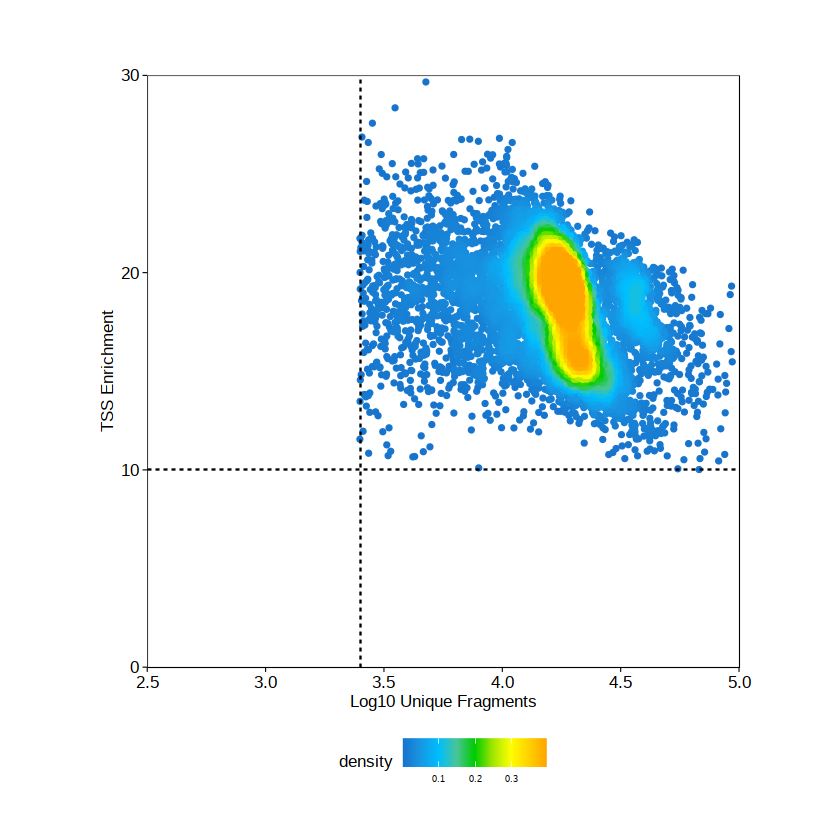

In [10]:
# df <- getCellColData(scatacProj, select = c("log10(nFrags)", "TSSEnrichment"))
# p <- ggPoint(
#     x = df[,1], 
#     y = df[,2], 
#     colorDensity = TRUE,
#     continuousSet = "sambaNight",
#     xlabel = "Log10 Unique Fragments",
#     ylabel = "TSS Enrichment",
#     xlim = c(2.5, 5),
#     ylim = c(0, 30)
# ) + geom_hline(yintercept = 10, lty = "dashed") + geom_vline(xintercept = 3.4, lty = "dashed")
# p

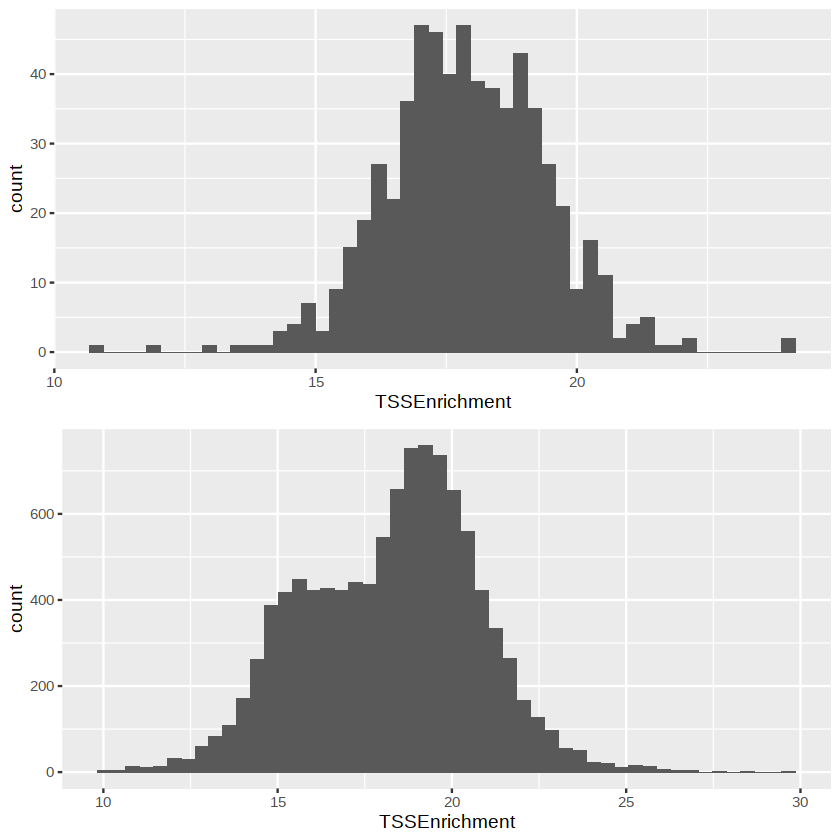

In [11]:
# # attributes(scatacProj)
# df = as.data.frame(getCellColData(scatacProj, select = c("DoubletEnrichment", "TSSEnrichment")))
# p1 <- ggplot(df[df['DoubletEnrichment']>=4,], aes(x=TSSEnrichment)) + geom_histogram(bins=50)
# p2 <- ggplot(df[df['DoubletEnrichment']<4,], aes(x=TSSEnrichment)) + geom_histogram(bins=50)
# grid.arrange(p1, p2, nrow = 2)

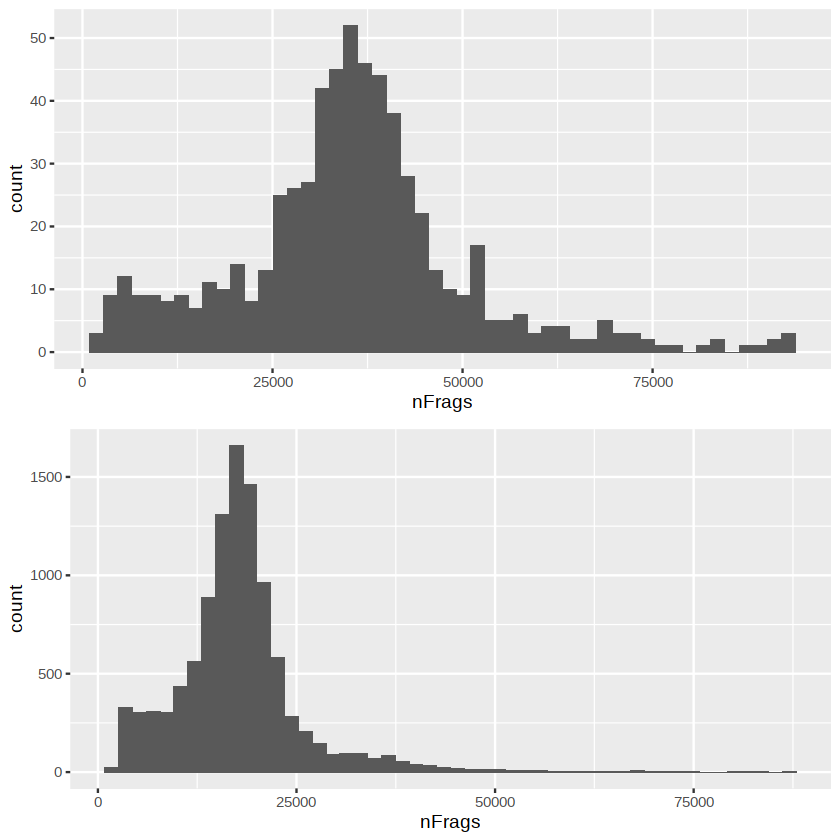

In [12]:
# df = as.data.frame(getCellColData(scatacProj, select = c("DoubletEnrichment", "nFrags")))
# p1 <- ggplot(df[df['DoubletEnrichment']>=4,], aes(x=nFrags)) + geom_histogram(bins=50)
# p2 <- ggplot(df[df['DoubletEnrichment']<4,], aes(x=nFrags)) + geom_histogram(bins=50)
# grid.arrange(p1, p2, nrow = 2)

In [8]:
TileMatrix <- getMatrixFromProject(scatacProj, useMatrix='TileMatrix', binarize=TRUE)
TileMatrix

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-12a6a3e894ce0-Date-2022-07-24_Time-18-47-19.log
If there is an issue, please report to github with logFile!

2022-07-24 18:50:01 : Organizing colData, 2.695 mins elapsed.

2022-07-24 18:50:01 : Organizing rowData, 2.695 mins elapsed.

2022-07-24 18:50:01 : Organizing rowRanges, 2.695 mins elapsed.

2022-07-24 18:50:01 : Organizing Assays (1 of 1), 2.695 mins elapsed.

2022-07-24 18:50:01 : Constructing SummarizedExperiment, 2.695 mins elapsed.

2022-07-24 18:50:03 : Finished Matrix Creation, 2.727 mins elapsed.



class: SummarizedExperiment 
dim: 6062095 11086 
metadata(0):
assays(1): TileMatrix
rownames: NULL
rowData names(3): seqnames idx start
colnames(11086): coassay_analysis#TAGCTAGGTTTGGGTA-1
  coassay_analysis#ACGAACAAGACACTTA-1 ...
  coassay_analysis#TCTAACCGTAGTCAAT-1
  coassay_analysis#ATTCGTTTCAGGTTTA-1
colData names(15): BlacklistRatio DoubletEnrichment ... Sample
  TSSEnrichment

In [10]:
# df$tilesum <- colSums(assays(TileMatrix)$TileMatrix, dims=1)
# p1 <- ggplot(df[df['DoubletEnrichment']>=4,], aes(x=tilesum)) + geom_histogram(bins=50)
# p2 <- ggplot(df[df['DoubletEnrichment']<4,], aes(x=tilesum)) + geom_histogram(bins=50)
# grid.arrange(p1, p2, nrow = 2)

In [16]:
# filterRatio threshold formula from 
# https://www.archrproject.com/reference/filterDoublets.html

# dim(df[df['DoubletEnrichment']>=4,])[1] / (dim(df)[1]**2/100000)

[1] 0.506105

In [11]:
# filter doublets

scatacProj <- filterDoublets(ArchRProj = scatacProj, filterRatio = 0.51)

Filtering 626 cells from ArchRProject!

	coassay_analysis : 626 of 11086 (5.6%)



# clustering

In [12]:
# LSI based on TileMatrix (reduce dimensionality)

scatacProj <- addIterativeLSI(ArchRProj = scatacProj, useMatrix = "TileMatrix", name = "IterativeLSI")

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-12a6a1d57422-Date-2022-07-24_Time-19-00-56.log
If there is an issue, please report to github with logFile!

2022-07-24 19:00:57 : Computing Total Across All Features, 0.001 mins elapsed.

2022-07-24 19:00:58 : Computing Top Features, 0.017 mins elapsed.

###########
2022-07-24 19:01:00 : Running LSI (1 of 2) on Top Features, 0.049 mins elapsed.
###########

2022-07-24 19:01:00 : Sampling Cells (N = 10000) for Estimated LSI, 0.05 mins elapsed.

2022-07-24 19:01:00 : Creating Sampled Partial Matrix, 0.05 mins elapsed.

2022-07-24 19:01:38 : Computing Estimated LSI (projectAll = FALSE), 0.68 mins elapsed.

2022-07-24 19:03:56 : Identifying Clusters, 2.978 mins elapsed.

2022-07-24 19:04:09 : Identified 6 Clusters, 3.21 mins elapsed.

2022-07-24 19:04:09 : Saving LSI Iteration, 3.21 mins elapsed.

2022-07-24 19:04:28 : Creating Cluster Matrix on the total Group Features, 3.522 mins elapsed.

2022-07-24 19:04:44 : Comput

In [13]:
# call clusters based on Seurat’s graph clustering

scatacProj <- addClusters(input = scatacProj, reducedDims = "IterativeLSI")

ArchR logging to : ArchRLogs/ArchR-addClusters-12a6a400ac09-Date-2022-07-24_Time-19-15-06.log
If there is an issue, please report to github with logFile!

2022-07-24 19:15:07 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.002 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10460
Number of edges: 403926

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8931
Number of communities: 20
Elapsed time: 1 seconds


2022-07-24 19:15:20 : Testing Biased Clusters, 0.222 mins elapsed.

2022-07-24 19:15:20 : Identified Biased Clusters (n = 2), set filterBias = TRUE to re-assign these cells: , 0.224 mins elapsed.

Biased Clusters : 
Cluster2 
Cluster6 


2022-07-24 19:15:20 : Testing Outlier Clusters, 0.224 mins elapsed.

2022-07-24 19:15:20 : Assigning Cluster Names to 20 Clusters, 0.224 mins elapsed.

2022-07-24 19:15:20 : Finished addClusters, 0.226 mins elapsed.



In [14]:
# UMAP and cluster

scatacProj <- addUMAP(ArchRProj = scatacProj, reducedDims = "IterativeLSI")

19:15:20 UMAP embedding parameters a = 0.7669 b = 1.223

19:15:20 Read 10460 rows and found 30 numeric columns

19:15:20 Using Annoy for neighbor search, n_neighbors = 40

19:15:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:15:21 Writing NN index file to temp file /tmp/RtmpWG752X/file12a6a791752e4

19:15:21 Searching Annoy index using 48 threads, search_k = 4000

19:15:21 Annoy recall = 100%

19:15:24 Commencing smooth kNN distance calibration using 48 threads

19:15:26 Initializing from normalized Laplacian + noise

19:15:26 Commencing optimization for 200 epochs, with 595252 positive edges

19:15:41 Optimization finished

19:15:41 Creating temp model dir /tmp/RtmpWG752X/dir12a6a2f6b298e

19:15:41 Creating dir /tmp/RtmpWG752X/dir12a6a2f6b298e

19:15:42 Changin

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-12a6a7bdb8538-Date-2022-07-24_Time-19-15-43.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-12a6a7bdb8538-Date-2022-07-24_Time-19-15-43.log



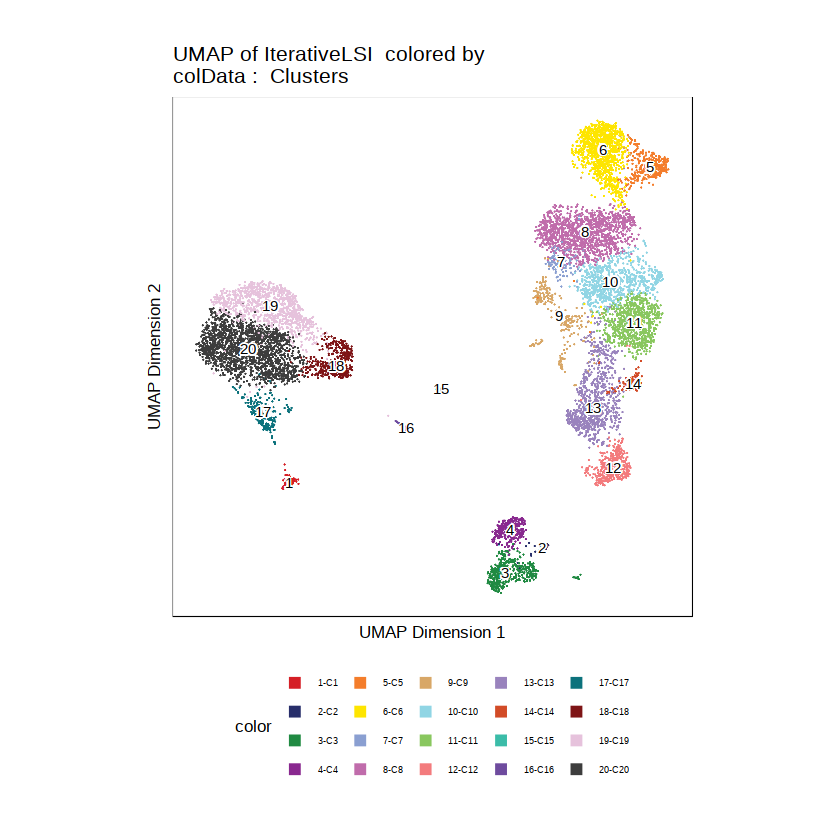

In [15]:
# plot clusters

pp <- plotEmbedding(ArchRProj = scatacProj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")
pp

In [16]:
# save figures
plotPDF(pp, name = "Plot-UMAP-Cell-Clusters.pdf",
        ArchRProj = scatacProj, addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!



# Assigning Clusters with Gene Scores

In [17]:
# add imputation weights using MAGIC to help smooth the dropout noise in our gene scores.

scatacProj <- addImputeWeights(scatacProj)

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-12a6a74731e8c-Date-2022-07-24_Time-19-17-16.log
If there is an issue, please report to github with logFile!

2022-07-24 19:17:16 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.

Warning message in sprintf("Completed Getting Magic Weights!", round(object.size(weightList)/10^9, :
“one argument not used by format 'Completed Getting Magic Weights!'”


In [18]:
# define marker genes and make plots

markerGenes  <- c(
    "CD4",  # helper T cell
    "CD8A",  # cytotoxic T cell 
    "CD79A",# B cell
    "TCF7", # memory and naïve T cells
    "IFNG", # CD8 effectors (cytotoxic T cells)
    "IKZF2", # regulatory T cells
    "CD28" # T cell activation
  )

p <- plotEmbedding(
    ArchRProj = scatacProj, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(scatacProj)
)

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-12a6af810508-Date-2022-07-24_Time-19-17-39.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2022-07-24 19:17:40 : 

1 


Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-12a6af810508-Date-2022-07-24_Time-19-17-39.log



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


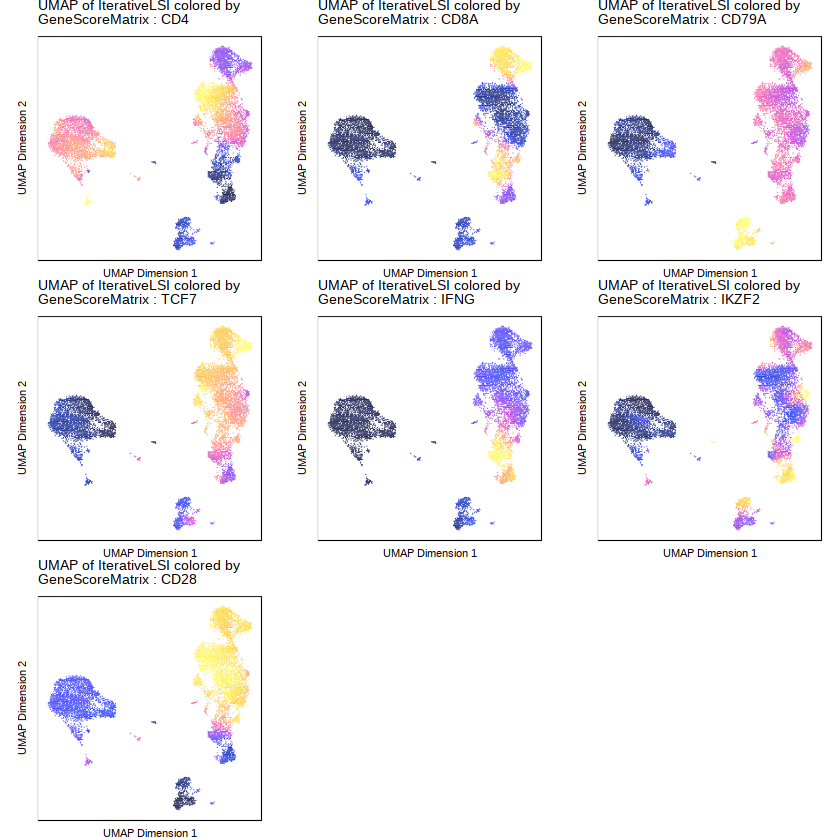

In [19]:
#Rearrange for grid plotting
p2 <- lapply(p, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p2))

In [26]:
# Method1: 
# CD4: 1, 3, 4, 5, 6, 7
# CD79A: 8, 9, 10
# CD8A: 11, 12, 19
# CD28: 13, 14, 15, 16
# IKZF2: 2, 17, 18
# Method2:
# CD4: 1, 3, 4, 5, 6, 7
# CD79A: 2, 8, 9, 10, 11, 12, 17, 18, 19
# CD28: 13, 14, 15, 16

In [20]:
plotPDF(plotList = p2, 
    name = "Plot-UMAP-Marker-Genes-W-Imputation.pdf", 
    ArchRProj = scatacProj, 
    addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!



# Visualizing Genome Browser Tracks

In [21]:
# browse the local chromatin accessibility at these marker genes on a per cluster basis with genome browser tracks

p <- plotBrowserTrack(
    ArchRProj = scatacProj, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-12a6a627fb0c9-Date-2022-07-24_Time-19-18-15.log
If there is an issue, please report to github with logFile!

2022-07-24 19:18:15 : Validating Region, 0.007 mins elapsed.



GRanges object with 7 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]    chr12     6786858-6820808      + |         920         CD4
  [2]     chr2   86784610-86808396      - |         925        CD8A
  [3]    chr19   41877120-41881372      + |         973       CD79A
  [4]     chr5 134114711-134151865      + |        6932        TCF7
  [5]    chr12   68154768-68159747      - |        3458        IFNG
  [6]     chr2 212999691-213152427      - |       22807       IKZF2
  [7]     chr2 203706475-203738912      + |         940        CD28
  -------
  seqinfo: 24 sequences from hg38 genome


2022-07-24 19:18:15 : Adding Bulk Tracks (1 of 7), 0.01 mins elapsed.

Getting Region From Arrow Files 1 of 1

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-07-24 19:18:17 : Adding Gene Tracks (1 of 7), 0.042 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-07-24 19:18:18 : Plotting, 0.049 mins elapsed.

2022-07-24 19:18:23 : Adding Bulk Tracks (2 of 7), 0.132 mins elapsed.

Getting Region From Arrow Files 1 of 1

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-07-24 19:18:25 : Adding Gene Tracks (2 of 7), 0.167 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-07-24 19:18:25 : Plotting, 0.172 mins elapsed.

2022-07-24 19:18:28 : Adding Bulk Tracks (3 of 7), 0.229 mins elapsed.

Getting Region From Arrow F

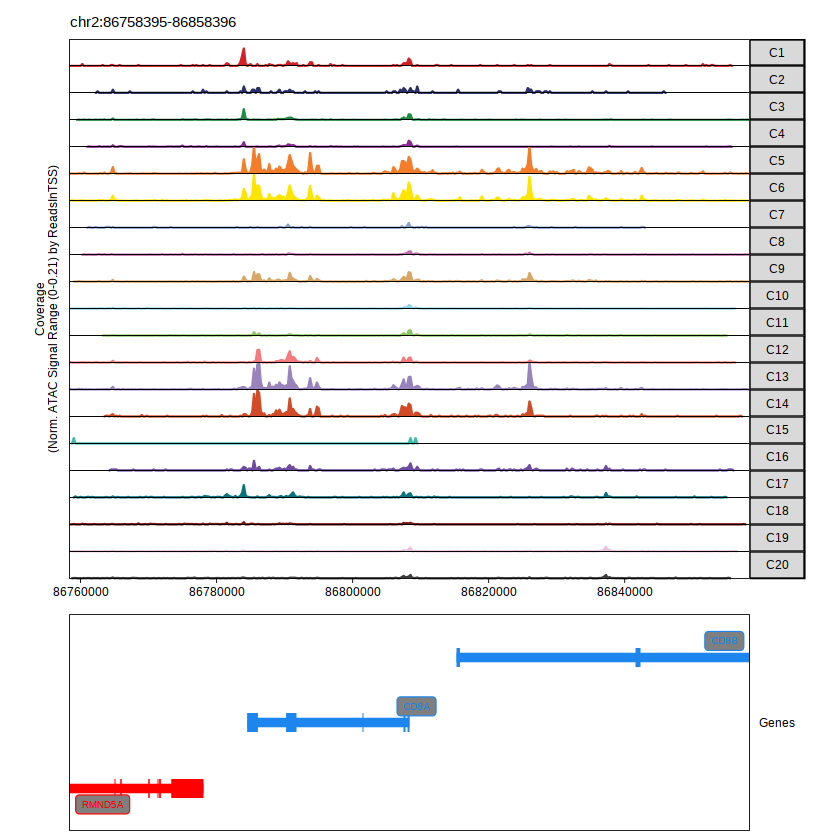

In [22]:
# plot CD14 gene accessibility at different clusters

grid::grid.newpage()
grid::grid.draw(p$CD8A)

In [23]:
plotPDF(plotList = p, 
    name = "Plot-Tracks-Marker-Genes.pdf", 
    ArchRProj = scatacProj, 
    addDOC = FALSE, width = 5, height = 5)

Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


In [24]:
saveArchRProject(ArchRProj = scatacProj, outputDirectory = archr_out, load = FALSE)

Saving ArchRProject...



In [35]:
scatacProj


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /Genomics/pritykinlab/zzhao/sc-atac-submmit-calling/sc-atac-submmit-calling/results/pbmc_archR_output 
samples(1): coassay_analysis
sampleColData names(1): ArrowFiles
cellColData names(16): Sample TSSEnrichment ... BlacklistRatio Clusters
numberOfCells(1): 10460
medianTSS(1): 18.544
medianFrags(1): 17399.5

In [42]:
motif_regression_out = "results/motif_regression_output/"
motif_regression_out = paste(root, motif_regression_out, sep="/")
write(getCellNames(scatacProj), paste(motif_regression_out, "ARCHR_cell_names_filtered.txt", sep="/"))

# Summit matrix

In [5]:
scatacProj <- loadArchRProject(path = archr_out)

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [6]:
getAvailableMatrices(scatacProj)

[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

In [7]:
motif_regression_out = "results/motif_regression_output/"
motif_regression_out = paste(root, motif_regression_out, sep="/")

In [8]:
summit.peaks <- rtracklayer::import(paste(motif_regression_out, "SUMMITS-all-atac-summits.bed", sep="/"))

In [9]:
summit.peaks

GRanges object with 226759 ranges and 2 metadata columns:
           seqnames              ranges strand |         name     score
              <Rle>           <IRanges>  <Rle> |  <character> <numeric>
       [1]     chr1         10097-10246      * |      summit1         0
       [2]     chr1       180832-180981      * |      summit2         0
       [3]     chr1       181391-181540      * |      summit3         0
       [4]     chr1       191457-191606      * |      summit4         0
       [5]     chr1       191776-191925      * |      summit5         0
       ...      ...                 ...    ... .          ...       ...
  [226755]     chrX 155891536-155891685      * | summit226755         0
  [226756]     chrX 155966995-155967144      * | summit226756         0
  [226757]     chrX 155997525-155997674      * | summit226757         0
  [226758]     chrX 156030122-156030271      * | summit226758         0
  [226759]     chrX 156030538-156030687      * | summit226759         0
  ----

In [10]:
scatac_peak <- addPeakSet(ArchRProj = scatacProj,
                          peakSet = summit.peaks,
                          genomeAnnotation = getGenomeAnnotation(scatacProj),
                          force = TRUE)

In [11]:
tail(getPeakSet(scatac_peak))

GRanges object with 6 ranges and 5 metadata columns:
      seqnames              ranges strand |         name     score       idx
         <Rle>           <IRanges>  <Rle> |  <character> <numeric> <integer>
  [1]     chrX 155881468-155881617      * | summit226754         0      5947
  [2]     chrX 155891536-155891685      * | summit226755         0      5948
  [3]     chrX 155966995-155967144      * | summit226756         0      5949
  [4]     chrX 155997525-155997674      * | summit226757         0      5950
  [5]     chrX 156030122-156030271      * | summit226758         0      5951
  [6]     chrX 156030538-156030687      * | summit226759         0      5952
             GC         N
      <numeric> <numeric>
  [1]    0.6467         0
  [2]    0.3867         0
  [3]    0.5467         0
  [4]    0.5267         0
  [5]    0.5667         0
  [6]    0.5067         0
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [12]:
scatac_peak <- addPeakMatrix(scatac_peak, ceiling = 20)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-186b777714aea-Date-2022-07-26_Time-09-29-07.log
If there is an issue, please report to github with logFile!

2022-07-26 09:29:07 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

2022-07-26 09:30:12 : Adding coassay_analysis to PeakMatrix for Chr (1 of 23)!, 0.02 mins elapsed.

2022-07-26 09:30:27 : Adding coassay_analysis to PeakMatrix for Chr (2 of 23)!, 0.267 mins elapsed.

2022-07-26 09:30:38 : Adding coassay_analysis to PeakMatrix for Chr (3 of 23)!, 0.446 mins elapsed.

2022-07-26 09:30:46 : Adding coassay_analysis to PeakMatrix for Chr (4 of 23)!, 0.592 mins elapsed.

2022-07-26 09:30:53 : Adding co

In [13]:
getAvailableMatrices(scatac_peak)

[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

In [14]:
PeakMatrix <- getMatrixFromProject(scatac_peak, useMatrix='PeakMatrix', binarize=FALSE)
PeakMatrix

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-186b763a5a4ba-Date-2022-07-26_Time-09-33-20.log
If there is an issue, please report to github with logFile!

2022-07-26 09:34:15 : Organizing colData, 0.917 mins elapsed.

2022-07-26 09:34:15 : Organizing rowData, 0.917 mins elapsed.

2022-07-26 09:34:15 : Organizing rowRanges, 0.917 mins elapsed.

2022-07-26 09:34:16 : Organizing Assays (1 of 1), 0.917 mins elapsed.

2022-07-26 09:34:16 : Constructing SummarizedExperiment, 0.917 mins elapsed.

2022-07-26 09:34:17 : Finished Matrix Creation, 0.934 mins elapsed.



class: RangedSummarizedExperiment 
dim: 226759 10460 
metadata(0):
assays(1): PeakMatrix
rownames: NULL
rowData names(2): idx name
colnames(10460): coassay_analysis#ACGAACAAGACACTTA-1
  coassay_analysis#TTATTGCTCATTACGA-1 ...
  coassay_analysis#TCTAACCGTAGTCAAT-1
  coassay_analysis#ATTCGTTTCAGGTTTA-1
colData names(18): BlacklistRatio DoubletEnrichment ... ReadsInPeaks
  FRIP

In [15]:
writeMM(assays(PeakMatrix)$PeakMatrix, paste(motif_regression_out, "ArchR_PBMC_peak_cell_matrix.mtx", sep="/"))

NULL

In [16]:
write.table(getPeakSet(scatacProj), paste(motif_regression_out, "ArchR_PBMC_peaks.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE, row.names = FALSE)
write.table(colData(PeakMatrix), paste(motif_regression_out, "ArchR_PBMC_cellnames_info.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE)

lsi_object = getReducedDims(
  ArchRProj = scatacProj,
  reducedDims = "IterativeLSI",
  returnMatrix = TRUE,
  dimsToUse = NULL,
  scaleDims = NULL,
  corCutOff = 0.75
)

write.table(lsi_object, paste(motif_regression_out, "ArchR_PBMC_Iterative_LSI.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE)

In [17]:
write.csv(rowData(PeakMatrix)['name'], paste(motif_regression_out, 'ArchR_matrix_summit_metadata.csv', sep="/"))

# Run ChiPseeker

In [18]:
library(ChIPseeker)

library(org.Hs.eg.db)

library(TxDb.Hsapiens.UCSC.hg38.knownGene)



Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

ChIPseeker v1.32.0  For help: https://guangchuangyu.github.io/software/ChIPseeker

If you use ChIPseeker in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Qing-Yu He. ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization. Bioinformatics 2015, 31(14):2382-2383

Loading required package: AnnotationDbi



Loading required package: GenomicFeatures



In [19]:
peak.names <- getPeakSet(scatac_peak)
names(peak.names) <- NULL
peakAnno <- annotatePeak(peak.names, 
                         TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene, 
                         annoDb="org.Hs.eg.db")

>> preparing features information...		 2022-07-26 09:40:30 AM 
>> identifying nearest features...		 2022-07-26 09:40:31 AM 
>> calculating distance from peak to TSS...	 2022-07-26 09:40:36 AM 
>> assigning genomic annotation...		 2022-07-26 09:40:36 AM 
>> adding gene annotation...			 2022-07-26 09:41:02 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-07-26 09:41:03 AM 
>> done...					 2022-07-26 09:41:03 AM 


In [20]:
write.table(as.data.frame(peakAnno@anno), paste(motif_regression_out, "ChIPseeker_PBMC_annotation.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE)




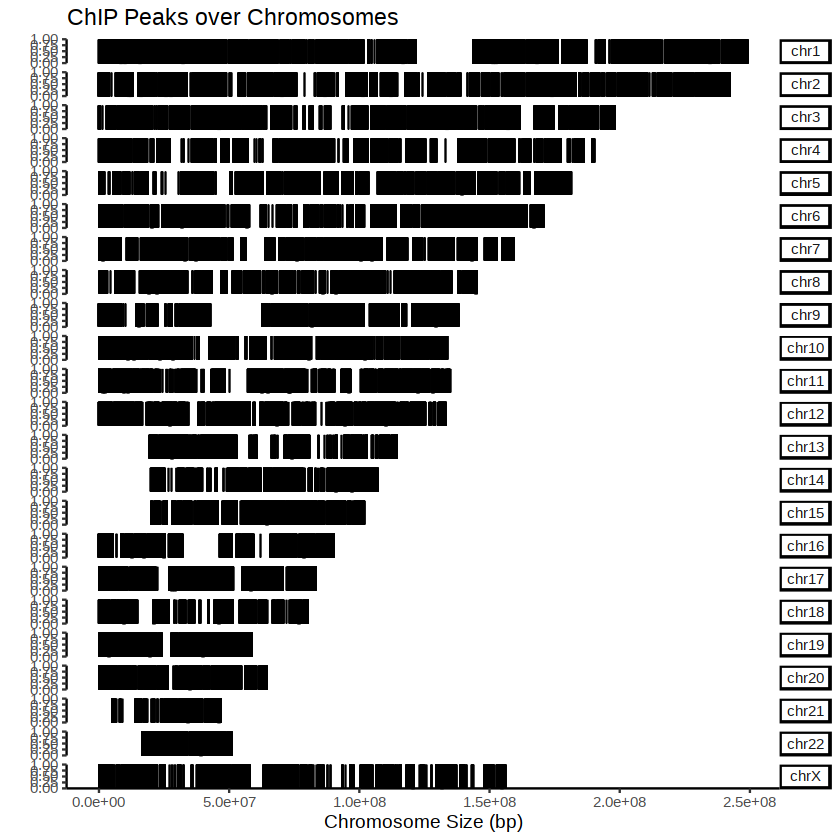

In [24]:
covplot(peak.names)

In [39]:
# CD4: 1, 3, 4, 5, 6, 7
# CD79A: 2, 8, 9, 10, 11, 12, 17, 18, 19
# CD28: 13, 14, 15, 16

remapClust <- c(
    "C1" = "CD4",
    "C2" = "CD79A",
    "C3" = "CD4",
    "C4" = "CD4",
    "C5" = "CD4",
    "C6" = "CD4",
    "C7" = "CD4",
    "C8" = "CD79A",
    "C9" = "CD79A",
    "C10" = "CD79A",
    "C11" = "CD79A",
    "C12" = "CD79A",
    "C13" = "CD28",
    "C14" = "CD28",
    "C15" = "CD28",
    "C16" = "CD28",
    "C17" = "CD79A",
    "C18" = "CD79A",
    "C19" = 'CD79A')

In [40]:
scatacProj$ClustersAnnotated2 <- mapLabels(scatacProj$Clusters, oldLabels = names(remapClust), newLabels = remapClust)

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-382f84f365077-Date-2022-06-03_Time-11-37-05.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-382f84f365077-Date-2022-06-03_Time-11-37-05.log



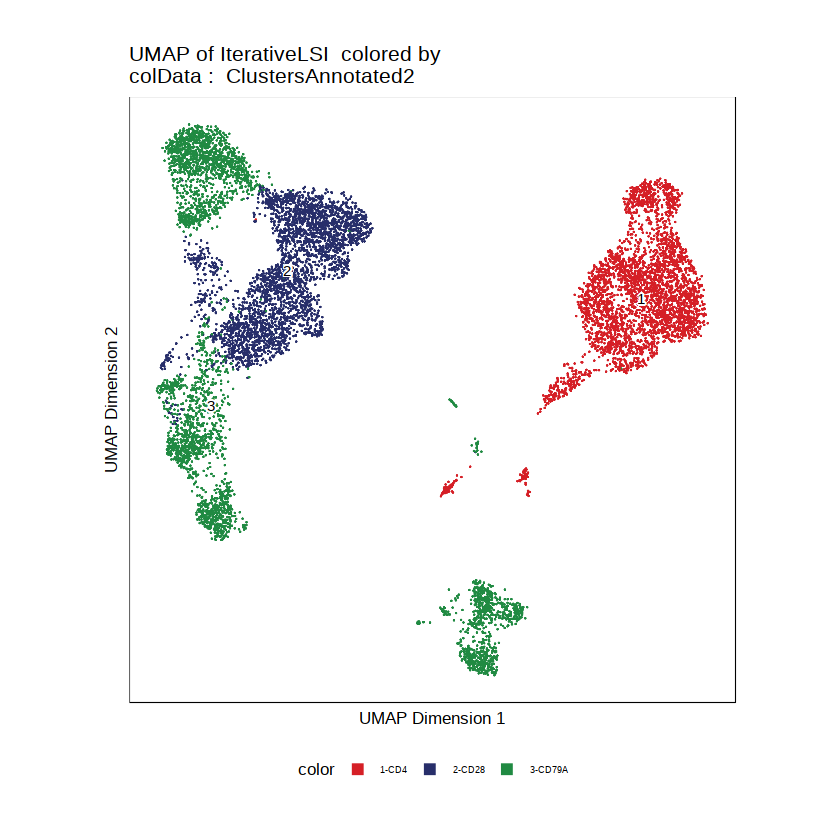

In [41]:
pp <- plotEmbedding(ArchRProj = scatacProj, colorBy = "cellColData", name = "ClustersAnnotated2", embedding = "UMAP")
pp

In [42]:
saveArchRProject(ArchRProj = scatacProj, outputDirectory = archr_out, load = FALSE)

Saving ArchRProject...



# peak calling

In [43]:
scatacProj$ClustersAnnotated2

[1] "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
   [10] "CD4"   "CD4"   "CD79A" "CD28"  "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
   [19] "CD4"   "CD28"  "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD28" 
   [28] "CD4"   "CD4"   "CD28"  "CD28"  "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
   [37] "CD79A" "CD4"   "CD28"  "CD79A" "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
   [46] "CD4"   "CD28"  "CD4"   "CD4"   "CD4"   "CD28"  "CD4"   "CD4"   "CD4"  
   [55] "CD4"   "CD28"  "CD4"   "CD28"  "CD28"  "CD4"   "CD79A" "CD79A" "CD28" 
   [64] "CD4"   "CD4"   "CD4"   "CD79A" "CD28"  "CD4"   "CD4"   "CD79A" "CD4"  
   [73] "CD4"   "CD79A" "CD4"   "CD79A" "CD4"   "CD4"   "CD4"   "CD79A" "CD4"  
   [82] "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
   [91] "CD4"   "CD28"  "CD4"   "CD79A" "CD28"  "CD4"   "CD4"   "CD4"   "CD4"  
  [100] "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD28"  "CD28" 
  [109] "CD4"   "CD28"  "CD4"   "CD4"   "CD28"  "CD28"  "CD28"  "CD4"   "CD4"  
  [118] "CD4"   "CD79A" "CD4"   "CD4"   "CD4"   "CD4"   "CD79A" "CD28"  "CD4"  
  [127] "CD79A" "CD4"   "CD28"  "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD28" 
  [136] "CD4"   "CD28"  "CD28"  "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
  [145] "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD79A" "CD4"  
  [154] "CD79A" "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD28"  "CD4"  
  [163] "CD4"   "CD4"   "CD28"  "CD4"   "CD4"   "CD79A" "CD4"   "CD4"   "CD4"  
  [172] "CD4"   "CD4"   "CD4"   "CD4"   "CD28"  "CD28"  "CD4"   "CD4"   "CD28" 
  [181] "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
  [190] "CD4"   "CD4"   "CD28"  "CD4"   "CD28"  "CD28"  "CD4"   "CD4"   "CD4"  
  [199] "CD28"  "CD4"   "CD79A" "CD4"   "CD4"   "CD28"  "CD79A" "CD4"   "CD28" 
  [208] "CD28"  "CD4"   "CD28"  "CD4"   "CD79A" "CD4"   "CD28"  "CD4"   "CD4"  
  [217] "CD28"  "CD28"  "CD28"  "CD4"   "CD79A" "CD28"  "CD28"  "CD4"   "CD28" 
  [226] "CD28"  "CD28"  "CD28"  "CD28"  "CD28"  "CD79A" "CD4"   "CD4"   "CD4"  
  [235] "CD79A" "CD4"   "CD28"  "CD4"   "CD28"  "CD79A" "CD28"  "CD28"  "CD28" 
  [244] "CD28"  "CD79A" "CD79A" "CD28"  "CD28"  "CD4"   "CD4"   "CD28"  "CD28" 
  [253] "CD28"  "CD4"   "CD28"  "CD28"  "CD28"  "CD28"  "CD28"  "CD79A" "CD4"  
  [262] "CD28"  "CD28"  "CD28"  "CD28"  "CD4"   "CD4"   "CD79A" "CD28"  "CD4"  
  [271] "CD4"   "CD4"   "CD4"   "CD28"  "CD28"  "CD28"  "CD28"  "CD4"   "CD28" 
  [280] "CD28"  "CD4"   "CD4"   "CD28"  "CD79A" "CD4"   "CD4"   "CD28"  "CD28" 
  [289] "CD4"   "CD28"  "CD28"  "CD28"  "CD4"   "CD28"  "CD4"   "CD79A" "CD28" 
  [298] "CD4"   "CD4"   "CD28"  "CD28"  "CD28"  "CD79A" "CD28"  "CD79A" "CD28" 
  [307] "CD28"  "CD4"   "CD28"  "CD79A" "CD4"   "CD28"  "CD4"   "CD28"  "CD28" 
  [316] "CD4"   "CD28"  "CD4"   "CD28"  "CD4"   "CD4"   "CD28"  "CD28"  "CD28" 
  [325] "CD28"  "CD79A" "CD28"  "CD4"   "CD4"   "CD79A" "CD28"  "CD4"   "CD28" 
  [334] "CD4"   "CD28"  "CD79A" "CD28"  "CD28"  "CD28"  "CD4"   "CD4"   "CD79A"
  [343] "CD4"   "CD28"  "CD28"  "CD28"  "CD4"   "CD4"   "CD4"   "CD28"  "CD28" 
  [352] "CD28"  "CD4"   "CD4"   "CD28"  "CD4"   "CD28"  "CD4"   "CD4"   "CD28" 
  [361] "CD79A" "CD4"   "CD28"  "CD4"   "CD28"  "CD28"  "CD4"   "CD79A" "CD28" 
  [370] "CD4"   "CD4"   "CD79A" "CD4"   "CD4"   "CD4"   "CD28"  "CD79A" "CD79A"
  [379] "CD28"  "CD4"   "CD28"  "CD28"  "CD28"  "CD4"   "CD28"  "CD28"  "CD79A"
  [388] "CD4"   "CD28"  "CD79A" "CD4"   "CD28"  "CD28"  "CD79A" "CD28"  "CD4"  
  [397] "CD4"   "CD4"   "CD28"  "CD28"  "CD4"   "CD4"   "CD4"   "CD28"  "CD4"  
  [406] "CD79A" "CD28"  "CD28"  "CD4"   "CD4"   "CD28"  "CD28"  "CD4"   "CD28" 
  [415] "CD4"   "CD28"  "CD28"  "CD4"   "CD4"   "CD28"  "CD4"   "CD28"  "CD4"  
  [424] "CD4"   "CD28"  "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD28"  "CD4"  
  [433] "CD4"   "CD28"  "CD79A" "CD4"   "CD79A" "CD4"   "CD28"  "CD28"  "CD28" 
  [442] "CD28"  "CD28"  "CD4"   "CD79A" "CD28"  "CD4"   "CD28"  "CD28"  "CD28" 
  [4

In [44]:
pathToMacs2 <- '/Genomics/grid/users/zz5084/anaconda3/envs/r/bin/macs2'
pathToMacs2

[1] "/Genomics/grid/users/zz5084/anaconda3/envs/r/bin/macs2"

In [45]:
scatacProj <- addGroupCoverages(scatacProj, groupBy = "ClustersAnnotated2", force = TRUE) 

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-382f851dcb3a9-Date-2022-06-03_Time-11-37-26.log
If there is an issue, please report to github with logFile!

CD4 (1 of 3) : CellGroups N = 2

CD28 (2 of 3) : CellGroups N = 2

CD79A (3 of 3) : CellGroups N = 2

2022-06-03 11:37:27 : Creating Coverage Files!, 0.018 mins elapsed.

2022-06-03 11:37:27 : Batch Execution w/ safelapply!, 0.018 mins elapsed.

2022-06-03 11:38:32 : Adding Kmer Bias to Coverage Files!, 1.105 mins elapsed.

Completed Kmer Bias Calculation

Adding Kmer Bias (1 of 6)

Adding Kmer Bias (2 of 6)

Adding Kmer Bias (3 of 6)

Adding Kmer Bias (4 of 6)

Adding Kmer Bias (5 of 6)

Adding Kmer Bias (6 of 6)

2022-06-03 11:39:08 : Finished Creation of Coverage Files!, 1.702 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addGroupCoverages-382f851dcb3a9-Date-2022-06-03_Time-11-37-26.log



In [27]:
?addReproduciblePeakSet()

In [46]:
scatacProj <- addReproduciblePeakSet(
    ArchRProj = scatacProj, 
    groupBy = "ClustersAnnotated2", 
    pathToMacs2 = pathToMacs2,
    force = TRUE
)

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-382f83e9339ee-Date-2022-06-03_Time-11-39-25.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2022-06-03 11:39:26 : Peak Calling Parameters!, 0.021 mins elapsed.



      Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
CD4     CD4   3571        540           2   40  500   150000
CD28   CD28   3281        540           2   40  500   150000
CD79A CD79A   3608        540           2   40  500   150000


2022-06-03 11:39:26 : Batching Peak Calls!, 0.021 mins elapsed.

2022-06-03 11:39:26 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-06-03 11:41:23 : Identifying Reproducible Peaks!, 1.977 mins elapsed.

2022-06-03 11:41:33 : Creating Union Peak Set!, 2.137 mins elapsed.

Converged after 4 iterations!

Plotting Ggplot!

2022-06-03 11:41:39 : Finished Creating Union Peak Set (89280)!, 2.243 mins elapsed.



In [47]:
head(getPeakSet(scatacProj))

GRanges object with 6 ranges and 13 metadata columns:
        seqnames        ranges strand |     score replicateScoreQuantile
           <Rle>     <IRanges>  <Rle> | <numeric>              <numeric>
    CD4     chr1 817096-817596      * | 147.29500                  0.886
    CD4     chr1 820721-821221      * |   3.16766                  0.228
    CD4     chr1 826608-827108      * |   3.16766                  0.228
    CD4     chr1 827290-827790      * | 298.87500                  0.939
  CD79A     chr1 857895-858395      * |  15.97850                  0.505
  CD79A     chr1 865600-866100      * |  17.29950                  0.523
        groupScoreQuantile Reproducibility GroupReplicate distToGeneStart
                 <numeric>       <numeric>    <character>       <integer>
    CD4              0.730               2     CD4._.Rep1              24
    CD4              0.034               2     CD4._.Rep2            3599
    CD4              0.034               2     CD4._.Rep2         

In [48]:
saveArchRProject(ArchRProj = scatacProj, outputDirectory = archr_out, load = FALSE)

Saving ArchRProject...



In [49]:
scatac_peak <- addPeakMatrix(scatacProj, ceiling = 20)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-382f8517a4b93-Date-2022-06-03_Time-11-43-40.log
If there is an issue, please report to github with logFile!

2022-06-03 11:43:40 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-06-03 11:43:41 : Adding coassay_analysis to PeakMatrix for Chr (1 of 23)!, 0.01 mins elapsed.

2022-06-03 11:44:02 : Adding coassay_analysis to PeakMatrix for Chr (2 of 23)!, 0.357 mins elapsed.

2022-06-03 11:44:16 : Adding coassay_analysis to PeakMatrix for Chr (3 of 23)!, 0.593 mins elapsed.

2022-06-03 11:44:27 : Adding coassay_analysis to PeakMatrix for Chr (4 of 23)!, 0.781 mins elapsed.

2022-06-03 11:44:36 : Adding coassay_analysis to PeakMatrix for Chr (5 of 23)!, 0.918 mins elapsed.

2022-06-03 11:44:45 : Adding coassay_analysis to PeakMatrix for Chr (6 of 23)!, 1.079 mins elapsed.

2022-06-03 11:44:57 : Adding coassay_analysis to PeakMatrix for Chr (7 of 23)!, 1.267 mins elapsed.

2022-06-03 11:45:06 : Adding coassay_analysis to PeakMatrix for C

In [50]:
getAvailableMatrices(scatac_peak)

[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

In [51]:
PeakMatrix <- getMatrixFromProject(scatacProj, useMatrix='PeakMatrix', binarize=FALSE)
PeakMatrix

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-382f81670eca1-Date-2022-06-03_Time-11-53-40.log
If there is an issue, please report to github with logFile!

2022-06-03 11:54:44 : Organizing colData, 1.063 mins elapsed.

2022-06-03 11:54:44 : Organizing rowData, 1.063 mins elapsed.

2022-06-03 11:54:44 : Organizing rowRanges, 1.063 mins elapsed.

2022-06-03 11:54:44 : Organizing Assays (1 of 1), 1.063 mins elapsed.

2022-06-03 11:54:44 : Constructing SummarizedExperiment, 1.064 mins elapsed.

2022-06-03 11:54:46 : Finished Matrix Creation, 1.107 mins elapsed.



class: RangedSummarizedExperiment 
dim: 89280 10460 
metadata(0):
assays(1): PeakMatrix
rownames: NULL
rowData names(1): idx
colnames(10460): coassay_analysis#AAACCGCGTACTTCAC-1
  coassay_analysis#GGTTGCGGTAAACAAG-1 ...
  coassay_analysis#TCTAACCGTAGTCAAT-1
  coassay_analysis#ATTCGTTTCAGGTTTA-1
colData names(18): BlacklistRatio DoubletEnrichment ...
  ClustersAnnotated ClustersAnnotated2

In [53]:
writeMM(assays(PeakMatrix)$PeakMatrix, paste(archr_out, "PBMC_peak_cell_matrix.mtx", sep="/"))

NULL

In [56]:
write.table(getPeakSet(scatacProj), paste(archr_out, "PBMC_peaks.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE, row.names = FALSE)
write.table(colData(PeakMatrix), paste(archr_out, "PBMC_cellnames_info.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE)

lsi_object = getReducedDims(
  ArchRProj = scatacProj,
  reducedDims = "IterativeLSI",
  returnMatrix = TRUE,
  dimsToUse = NULL,
  scaleDims = NULL,
  corCutOff = 0.75
)

write.table(lsi_object, paste(archr_out, "PBMC_Iterative_LSI.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE)

# Load from summit calling

In [6]:
scatacProj <- loadArchRProject(path = archr_out)

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [7]:
getAvailableMatrices(scatacProj)

[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

In [8]:
getGenomeAnnotation(scatacProj)

List of length 3
names(3): blacklist genome chromSizes

In [9]:
summit.peaks <- rtracklayer::import('all-atac-summits.bed')

In [10]:
summit.peaks

GRanges object with 79036 ranges and 2 metadata columns:
          seqnames              ranges strand |        name     score
             <Rle>           <IRanges>  <Rle> | <character> <numeric>
      [1]     chr1       817316-817465      * |     summit1         0
      [2]     chr1       820887-821036      * |     summit2         0
      [3]     chr1       827580-827729      * |     summit3         0
      [4]     chr1       858070-858219      * |     summit4         0
      [5]     chr1       865736-865885      * |     summit5         0
      ...      ...                 ...    ... .         ...       ...
  [79032]     chrX 155611489-155611638      * | summit79032         0
  [79033]     chrX 155612791-155612940      * | summit79033         0
  [79034]     chrX 155632608-155632757      * | summit79034         0
  [79035]     chrX 155841451-155841600      * | summit79035         0
  [79036]     chrX 155881219-155881368      * | summit79036         0
  -------
  seqinfo: 23 sequences

In [11]:
scatac_peak<- addPeakSet(ArchRProj = scatacProj,
                         peakSet = summit.peaks,
                         genomeAnnotation = getGenomeAnnotation(scatacProj),
                         force = TRUE)

In [12]:
head(getPeakSet(scatac_peak))

GRanges object with 6 ranges and 5 metadata columns:
      seqnames        ranges strand |        name     score       idx        GC
         <Rle>     <IRanges>  <Rle> | <character> <numeric> <integer> <numeric>
  [1]     chr1 817316-817465      * |     summit1         0         1    0.5533
  [2]     chr1 820887-821036      * |     summit2         0         2    0.5667
  [3]     chr1 827580-827729      * |     summit3         0         3    0.7333
  [4]     chr1 858070-858219      * |     summit4         0         4    0.4200
  [5]     chr1 865736-865885      * |     summit5         0         5    0.4600
  [6]     chr1 869849-869998      * |     summit6         0         6    0.7933
              N
      <numeric>
  [1]         0
  [2]         0
  [3]         0
  [4]         0
  [5]         0
  [6]         0
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [13]:
scatac_peak <- addPeakMatrix(scatac_peak, ceiling = 20)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-372a77a407645-Date-2022-06-08_Time-15-11-49.log
If there is an issue, please report to github with logFile!

2022-06-08 15:11:49 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

2022-06-08 15:13:02 : Adding coassay_analysis to PeakMatrix for Chr (1 of 23)!, 0.009 mins elapsed.

2022-06-08 15:13:21 : Adding coassay_analysis to PeakMatrix for Chr (2 of 23)!, 0.331 mins elapsed.

2022-06-08 15:13:31 : Adding coassay_analysis to PeakMatrix for Chr (3 of 23)!, 0.502 mins elapsed.

2022-06-08 15:13:41 : Adding coassay_analysis to PeakMatrix for Chr (4 of 23)!, 0.671 mins elapsed.

2022-06-08 15:13:48 : Adding c

In [14]:
PeakMatrix <- getMatrixFromProject(scatac_peak, useMatrix='PeakMatrix', binarize=FALSE)
PeakMatrix

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-372a7683a7af8-Date-2022-06-08_Time-15-16-36.log
If there is an issue, please report to github with logFile!

2022-06-08 15:17:27 : Organizing colData, 0.858 mins elapsed.

2022-06-08 15:17:27 : Organizing rowData, 0.858 mins elapsed.

2022-06-08 15:17:27 : Organizing rowRanges, 0.858 mins elapsed.

2022-06-08 15:17:27 : Organizing Assays (1 of 1), 0.859 mins elapsed.

2022-06-08 15:17:27 : Constructing SummarizedExperiment, 0.859 mins elapsed.

2022-06-08 15:17:29 : Finished Matrix Creation, 0.882 mins elapsed.



class: RangedSummarizedExperiment 
dim: 79036 10460 
metadata(0):
assays(1): PeakMatrix
rownames: NULL
rowData names(2): idx name
colnames(10460): coassay_analysis#AAACCGCGTACTTCAC-1
  coassay_analysis#GGTTGCGGTAAACAAG-1 ...
  coassay_analysis#TCTAACCGTAGTCAAT-1
  coassay_analysis#ATTCGTTTCAGGTTTA-1
colData names(20): BlacklistRatio DoubletEnrichment ... ReadsInPeaks
  FRIP

In [15]:
writeMM(assays(PeakMatrix)$PeakMatrix, paste(archr_out, "PBMC_summit_cell_matrix.mtx", sep="/"))

NULL

In [16]:
write.table(getPeakSet(scatac_peak), paste(archr_out, "PBMC_summit.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE, row.names = FALSE)



